In [2]:
import time 
import numpy as np
import pandas as pd
from scipy import signal
import csv
import os
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [42]:
def upsample_old(x, os_factor):
    out = np.zeros((int(len(x)*os_factor)))
    for i in enumerate(x):
        if i[1] == '1':
            if i[0] == len(x):
                out[int(np.round(i[0]*os_factor,0)):] = 1
            else:
                out[int(np.round(i[0]*os_factor,0)):int(np.round((i[0]+1)*os_factor,0))] = 1 
        return out

def upsample(x, os_factor):
    # recall: os_factor is either ratio of sampling frequency and carrier frequency (fs/fc), 
    # or ratio of bit period (1/bitrate) to sample period (1/fs) - (fs*minbit) for basebanded waveform
    codeArr = np.zeros(len(x))
    for i in enumerate(x):
        if i[1]=='1':
            codeArr[i[0]] = 1    
    bipolCodeArr = codeArr*2-1
    out = np.repeat(codeArr,os_factor)
    return out

def make_BPSK_pulse(A, code, fs, fc, minbit):
    sync = upsample(code, fs*minbit)
    fakeTime = np.arange(0,len(sync))*1/fs
    # For a bpsk pulse this works because pi is 180 degrees, so pi*1 and pi*0 gives a phase difference of 180 degrees, with 180 degrees encoding binary 1, and 0 encoding binary 0
    # What if I shift the phase so that both values are nonzero?
    bpskPulse = A*np.exp(1j*(2*np.pi*fc*(fakeTime+np.pi*sync)))
    return bpskPulse             

# Generate test pulse

### Define globals

In [95]:
A = 1
fs = 25e6
noiseAmp = 100
minbit = 1e-6
bitrate = 1/minbit
pw = 8*minbit
dec = int(randCodes.Code[0],2)
fc = 5e6
words = pd.read_csv("allPossible8bitWords.csv",dtype=str)      
randCodes = words.sample(n=1).reset_index()
code = randCodes.Code[0]
dec = int(code,2)
t = np.arange(-pw/2, pw/2, 1/fs)
raw_sig = make_BPSK_pulse(A, code, fs, fc, minbit)
mf = make_BPSK_pulse(A, code, fs, fc, minbit) # not even pretending here

for x in enumerate(code):
    if x[0] == 0:
        orthoCode = str(1-int(x[1]))
    else:
        orthoCode += str(1-int(x[1]))
orthogMF =  make_BPSK_pulse(A, orthoCode, fs, fc, minbit)
pulse = raw_sig + (1/10)*np.random.normal(0,1,len(t)) # decide later
print(f'The chosen code for this example is {code} with decimal value {dec}')

The chosen code for this example is 01011100 with decimal value 92


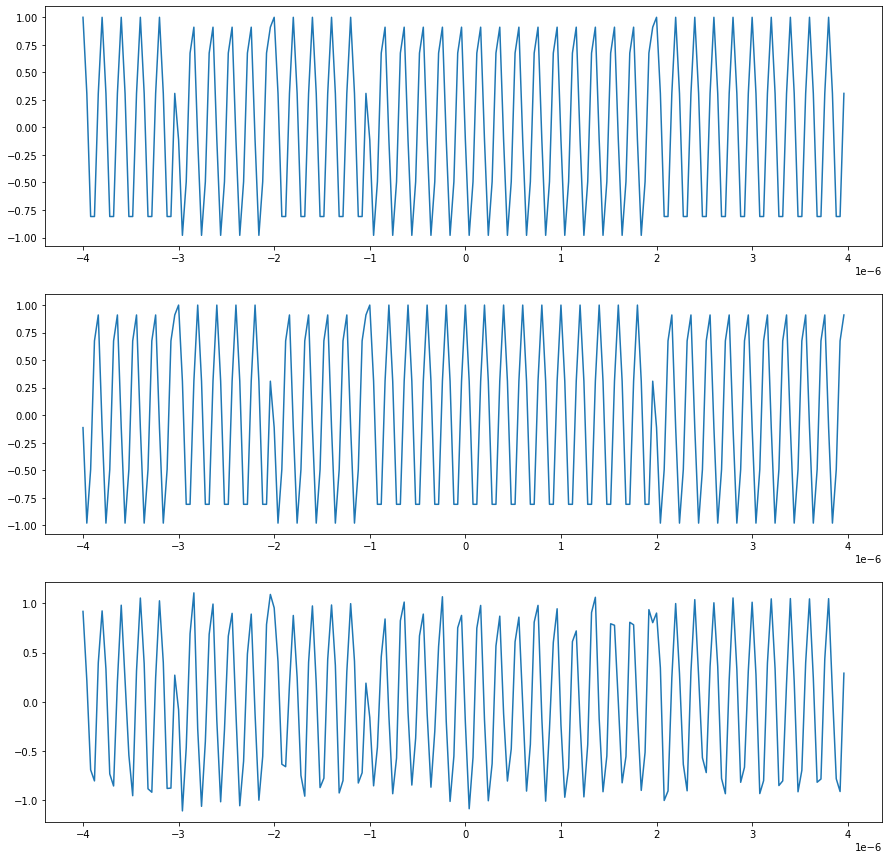

In [96]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(t,raw_sig.real)
plt.subplot(3,1,2)
plt.plot(t,orthogMF.real)
plt.subplot(3,1,3)
plt.plot(t,pulse.real)

Text(0.5, 1.0, 'This is the convolved correct code')

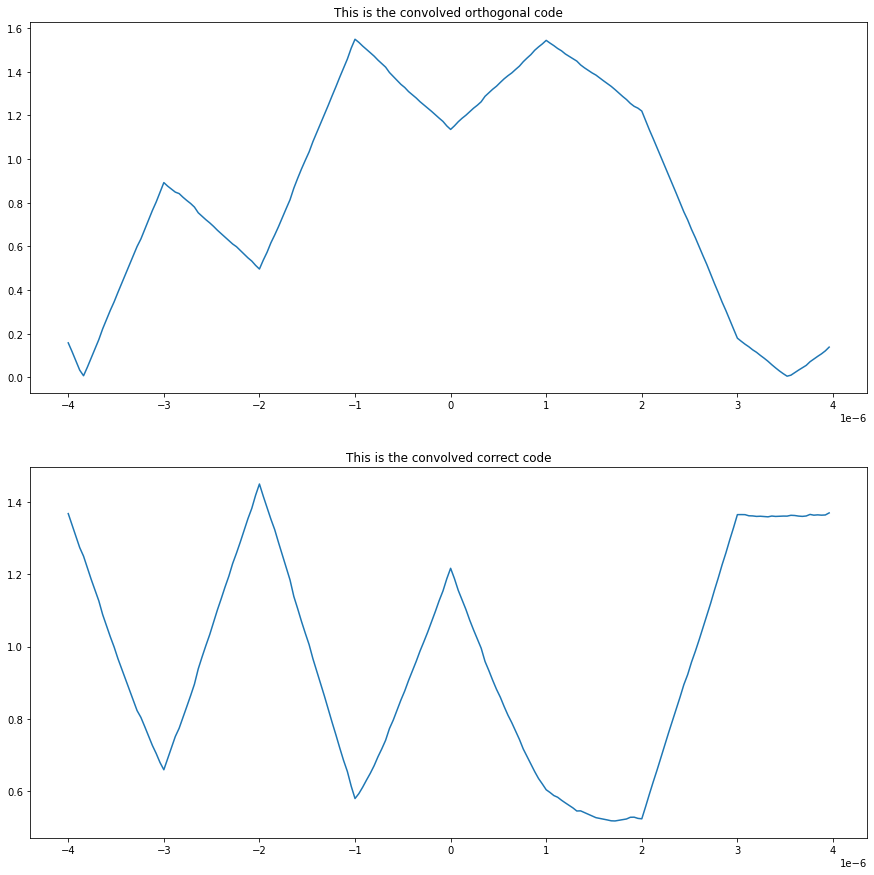

In [98]:
badFiltered = signal.convolve(pulse, orthogMF, mode='same')
badPSD = 20 * np.log10(badFiltered/np.mean(badFiltered))
badZ = np.abs((badFiltered - np.mean(badFiltered))/(np.std(badFiltered)))
goodFiltered = signal.convolve(pulse, raw_sig, mode='same')
gudPSD = 20 * np.log10(goodFiltered/np.mean(goodFiltered))
gudZ = np.abs((goodFiltered - np.mean(goodFiltered))/(np.std(goodFiltered)))
# To compute z-score, take convolution output, subtract mean, and then divide by standard deviation
# To compute power, take 20 * log_base10 of (the output / mean)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(t,np.abs(badZ))
plt.title('This is the convolved orthogonal code')
plt.subplot(2,1,2)
plt.plot(t,np.abs(gudZ))
plt.title('This is the convolved correct code')

# To Be Implemented

### This is the Muller and Mueller Clock Recovery Technique

In [ ]:
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on

### The Costas Loop for Fine Frequency Synchronization (as opposed to Coarse Frequency Synchronization)

In coarse frequency synchronization we square (BPSK) or square-square (totally a real math term) (QPSK) the incoming signal, find the frequency offset from that and subtract it off, then theoretically can demodulate our signal.

In [ ]:
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.132
beta = 0.00932
out = np.zeros(N, dtype=np.complex)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

# Plot freq over time to see how long it takes to hit the right offset
plt.plot(freq_log,'.-')
plt.show()